## Quick Regression Example on using Xgboost and Skater

In [1]:
%matplotlib inline
import matplotlib.pyplot
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression

import matplotlib.pyplot as plt
# Reference for customizing matplotlib: https://matplotlib.org/users/style_sheets.html
plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Load Bosting housing data
regressor_data = load_boston()
# Get information about the data
print(regressor_data.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

In [2]:
regressor_X = regressor_data.data
regressor_y = regressor_data.target

In [3]:
regressor_data.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [4]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
# XGRegressor example
xgb = XGBRegressor(objective='reg:linear', booster='gbtree', n_jobs= -1)

In [5]:
#XGB parameters for grid search
xgb_grid = {"max_depth" : [6],
"learning_rate" : [0.2],
"gamma" : [0],
"n_estimators" : [150],
"min_child_weight" : [1],
"base_score" : [0.5],
"subsample" : [1],
"max_delta_step" : [0],
"colsample_bytree" : [0.5],
"colsample_bylevel" : [0.4],
"reg_alpha" : [0],
"reg_lambda" : [60],
"scale_pos_weight" : [1]
}

clf = GridSearchCV(xgb, param_grid = xgb_grid, cv = 3, n_jobs = -1)
clf.fit(regressor_X, regressor_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [6], 'learning_rate': [0.2], 'gamma': [0], 'n_estimators': [150], 'min_child_weight': [1], 'base_score': [0.5], 'subsample': [1], 'max_delta_step': [0], 'colsample_bytree': [0.5], 'colsample_bylevel': [0.4], 'reg_alpha': [0], 'reg_lambda': [60], 'scale_pos_weight': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [6]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [7]:
y_hat = clf.predict(regressor_X)
print(mean_squared_error(regressor_y, y_hat))
print(r2_score(regressor_y, y_hat))

1.7361768728736837
0.9794339492894043


### Inference with Skater 

In [8]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

interpreter = Interpretation(regressor_X, feature_names=regressor_data.feature_names)
annotated_model = InMemoryModel(clf.predict, examples=regressor_X)
print("Number of classes: {}".format(annotated_model.n_classes))
print("Input shape: {}".format(annotated_model.input_shape))
print("Model Type: {}".format(annotated_model.model_type))
print("Output Shape: {}".format(annotated_model.output_shape))
print("Output Type: {}".format(annotated_model.output_type))
print("Returns Probabilities: {}".format(annotated_model.probability))

Number of classes: 1
Input shape: (506, 13)
Model Type: regressor
Output Shape: (506,)
Output Type: continuous
Returns Probabilities: not applicable


2-way partial dependence plots


2018-06-17 08:32:20,626 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False
2018-06-17 08:32:20,628 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[900/900] grid cells ████████████████████ Time elapsed: 49 seconds

[[<Figure size 1152x720 with 2 Axes>,

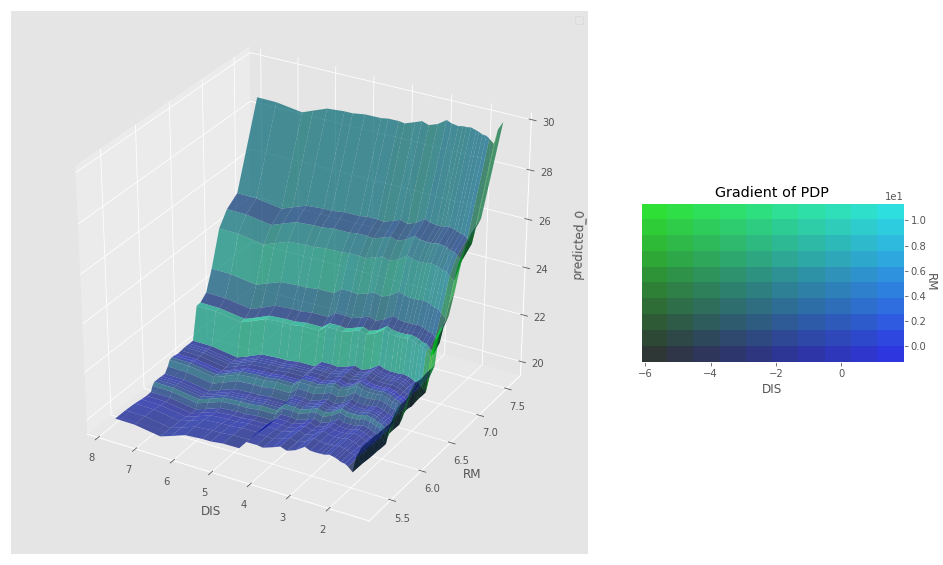

In [9]:
# There is some issue in the way xgboost handles the thread pool for concurrency and other multiprocessing python 
# libraries. For more information follow the discussion at the below mentioned links
# 1. https://github.com/datascienceinc/Skater/issues/212
# 2. https://github.com/dmlc/xgboost/issues/2163
# 3. http://scikit-learn.org/stable/faq.html#why-do-i-sometime-get-a-crash-freeze-with-n-jobs-1-under-osx-or-linux
# Workaround: The current workaround is to use n_jobs=

print("2-way partial dependence plots")
# Features can passed as a tuple for 2-way partial plot
pdp_features = [('DIS', 'RM')]
interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, annotated_model, grid_resolution=30, n_jobs=1
)

1-way partial dependence plots


2018-06-17 08:33:25,115 - skater.core.explanations - WARNING - Multiprocessing failed, going single process
2018-06-17 08:33:26,126 - skater.core.explanations - WARNING - Multiprocessing failed, going single process


[[<Figure size 1152x720 with 1 Axes>,
 [<Figure size 1152x720 with 1 Axes>,

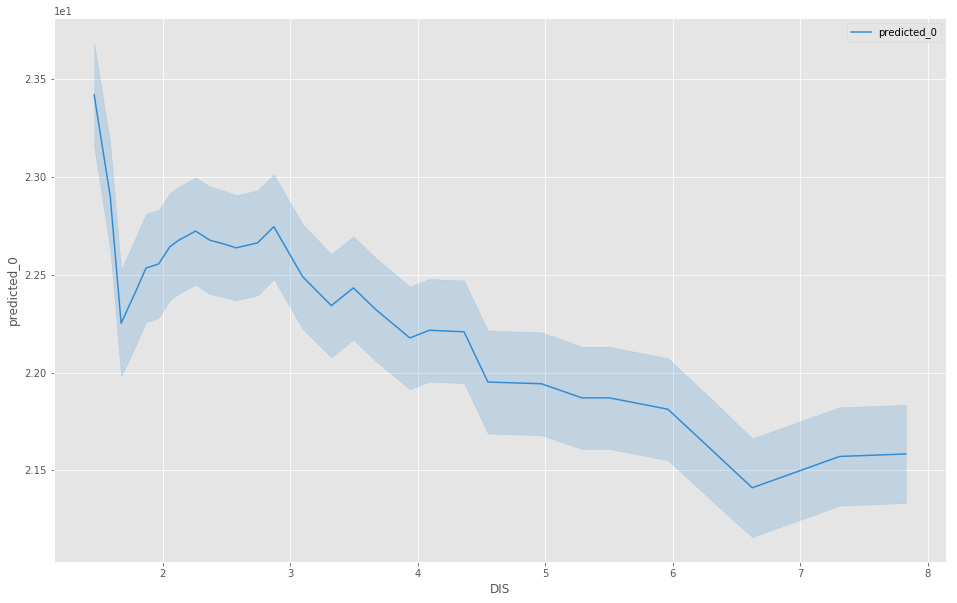

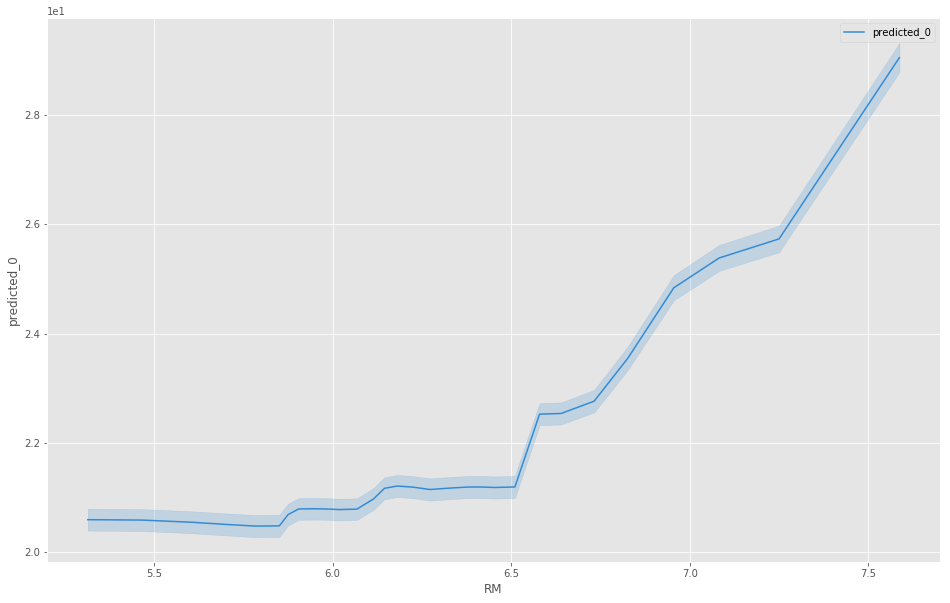

In [10]:
print("1-way partial dependence plots")
# or as independent features for 1-way partial plots
pdp_features = ['DIS', 'RM']
interpreter.partial_dependence.plot_partial_dependence(
    pdp_features, annotated_model, grid_resolution=30, progressbar=False, n_jobs=1, with_variance=True
)